<a href="https://colab.research.google.com/github/gshreya5/colab/blob/main/predict_medical_expense_linear_regression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# PREDICTING 💉MEDICAL 🧾 EXPENSES USING LINEAR REGRESSION
-- Part of Jovian CourseWork

**GOAL** : ACME Insurance Inc. offers affordable health insurance to thousands of customer all over the United States. We need to create an automated system to estimate the annual medical expenditure for new customers, using information such as their age, sex, BMI, children, smoking habits and region of residence.

Estimates from your system will be used to determine the annual insurance premium (amount paid every month) offered to the customer. Due to regulatory requirements, we must be able to explain why the system outputs a certain prediction.

# Load libraries

In [316]:
import numpy as np
import pandas as pd

import plotly.express as px
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

# Load data

In [317]:
df = pd.read_csv('https://raw.githubusercontent.com/JovianML/opendatasets/master/data/medical-charges.csv')

In [318]:
df.head(2)

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.90,0,yes,southwest,16884.9240
1,18,male,33.77,1,no,southeast,1725.5523


In [319]:
df.shape

(1338, 7)

The dataframe contains 1338 rows and 7 columns.

Let's check the data type for each column.

In [320]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1338 non-null   int64  
 1   sex       1338 non-null   object 
 2   bmi       1338 non-null   float64
 3   children  1338 non-null   int64  
 4   smoker    1338 non-null   object 
 5   region    1338 non-null   object 
 6   charges   1338 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 73.3+ KB


None of the columns have null values.

Columns sex,smoker,region are strings rest 4 are numerical.

Let's look at some of the statistics for the dataframe.

In [321]:
df.describe()

,age,bmi,children,charges
count,1338.000000,1338.000000,1338.000000,1338.000000
mean,39.207025,30.663397,1.094918,13270.422265
std,14.049960,6.098187,1.205493,12110.011237
min,18.000000,15.960000,0.000000,1121.873900
25%,27.000000,26.296250,0.000000,4740.287150
50%,39.000000,30.400000,1.000000,9382.033000
75%,51.000000,34.693750,2.000000,16639.912515
max,64.000000,53.130000,5.000000,63770.428010


"Ages" start at 18, which means no negative values, thus we may not need to clean this column. Looking at "BMI" values, quartile 1 (25th percentile) is more than the healthy weight range of 18 to 25. The "charges" column seems to be significantly skewed however, as the median (50 percentile) is much lower than the maximum value.  

# Exploratory Analysis and Visualization


Following settings are implemented to make charts, figures more visually appealing

In [322]:
sns.set_style('darkgrid')
plt.rcParams['font.size'] = 14
plt.rcParams['figure.figsize'] = (15, 6)
plt.rcParams['figure.facecolor'] = '#00000000'

## Distribution of Age

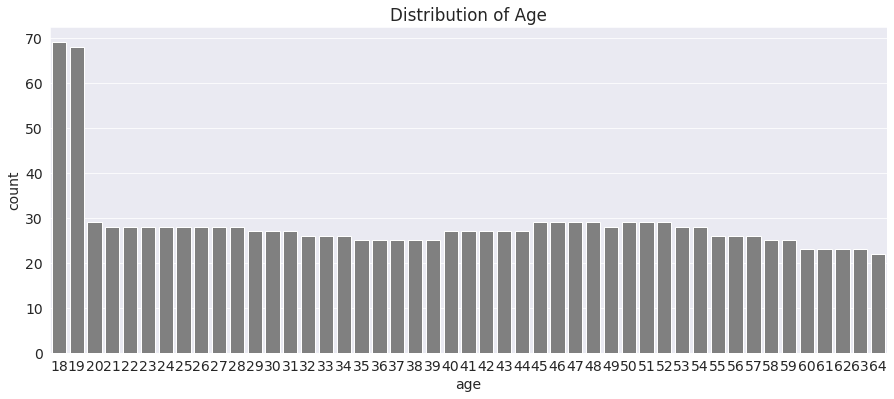

In [323]:
sns.countplot(data=df,x='age',color='gray').set_title("Distribution of Age");

Data seems to have more records for 18, 19 year olds in comparision to other ages. This may be because of lower premiums being offered to ages 18,19.
Ages are mostly uniformly distributed.

## BMI

In [324]:
fig = px.histogram(df, 
                   x='bmi', 
                   marginal='box', 
                   color='sex', 
                   title='Distribution of BMI (Body Mass Index)')
fig.add_vrect(x0=18.5,x1=29.9, fillcolor="green", opacity=0.2, line_width=0, annotation_text=" normal weight range ",)
fig.update_layout(bargap=0.1)
fig.show()

BMI seems to be making a bell shape as in a gaussian distribution around value 30 with few outliers to the right. There doesn't seem to be much difference in BMI between genders. About 50% do not have a normal BMI, which might be influencing high premiums because of weight related medical issues. 

## Charges and Smoker

In [325]:
fig = px.histogram(df, 
                   x='charges', 
                   marginal='box', 
                   color = 'smoker',
                   color_discrete_sequence=['green', 'grey'], 
                   title='Medical Charges ')
fig.update_layout(bargap=0.1)
fig.show()

* For most customers, the annual medical charges are under $11,000. Only a small fraction of customer have higher medical expenses, possibly due to accidents, major illnesses and genetic diseases. The distribution follows a "power law" (charges increasing as medical liability increases).

* There is a significant difference in medical expenses between smokers and non-smokers. While the median for non-smokers is \$7,300 and the median for smokers is close to $35,000.

## Charges and sex

In [326]:
fig = px.histogram(df, 
                   x='charges', 
                   marginal='box', 
                   color = 'sex',
                   title='Medical Charges ')
fig.update_layout(bargap=0.1)
fig.show()

Charges are distributed the same and follow power law across gender

# Smoker

In [327]:
fig = px.histogram(df, 
                   x='smoker', 
                   color ='sex',
                   title='Distribution of Smokers')
fig.show()

Looks like more males smoke in comparision to females.

Looks like about 20% of people smoke. 

This seems to be in line with 2010 cdc released report https://www.cdc.gov/mmwr/preview/mmwrhtml/mm6035a5.htm 

## Sex

In [328]:
df.sex.value_counts()

male      676
female    662
Name: sex, dtype: int64

## Region

In [329]:
df.region.value_counts()

southeast    364
southwest    325
northwest    325
northeast    324
Name: region, dtype: int64

About the same number across both genders and regions, which is good because it means our model won't be bias.

## Children

In [330]:
df.children.value_counts()

0    574
1    324
2    240
3    157
4     25
5     18
Name: children, dtype: int64

## Age and Charges


In [331]:
fig = px.scatter(df, 
                 x='age', 
                 y='charges', 
                 color='smoker', 
                 opacity=0.8, 
                 hover_data=['sex'], 
                 title='Age vs. Charges')
fig.update_traces(marker_size=5)
fig.show()

 It seems that medical charges increase with age, as we might expect.

 There seems to be 3 clusters:
 1. Healthy Non smokers (low premiums)
 2. Avg. premiums payers, with a mix of both smokers and non-smokers
 3. Unhealthy smokers (high premiums)

In [332]:
fig = px.scatter(df, 
                 x='age', 
                 y='charges', 
                 color='sex', 
                 opacity=0.8, 
                 hover_data=['sex'], 
                 title='Age vs. Charges')
fig.update_traces(marker_size=5)
fig.show()

When looking at distribution of sex in AGE vs CHARGES, as was in case of smokers, there are 3 clusters, all a mix of both genders:
* low premium payers
* avg premium payers
* high premium payers


## BMI and Charges


In [333]:
fig = px.scatter(df, 
                 x='bmi', 
                 y='charges', 
                 color='smoker', 
                 opacity=0.8, 
                 hover_data=['sex'], 
                 title='BMI vs. Charges')
fig.update_traces(marker_size=5)
fig.show()

It appears that for non-smokers, an increase in BMI doesn't seem to be related to an increase in medical charges. However, medical charges seem to be significantly higher for smokers with a BMI greater than 30.

## Charges and Children

In [334]:
px.violin(df, 
          x='children', 
          y='charges', 
          color='sex',
          title='Children vs. Charges')

As number of children increase, charges do slightly increase although not by a lot

## Charges and Region

In [335]:
px.violin(df, 
          x='region', 
          y='charges', 
          color='sex',title = 'region vs. Charges')

Charges vs region and Charges vs children show similar disparity in gender.  

# Correlation

Let's convert object datatype to numericals to help with correlation

In [336]:
sex_values = {'male':0,'female':1}
df['sex_n'] = df.sex.map(sex_values)

In [337]:
smoker_values = {'no':0,'yes':1}
df['smoker_n'] = df.smoker.map(smoker_values)

In [338]:
region_values = {'southwest':0,'southeast':1,'northwest':2,'northeast':3}
df['region_n'] = df.region.map(region_values)

In [339]:
df.corr()[['charges']]

,charges
age,0.299008
bmi,0.198341
children,0.067998
charges,1.000000
sex_n,-0.057292
smoker_n,0.787251
region_n,0.006208


smoker seems to have the highest positive correlation with charges than age and bmi

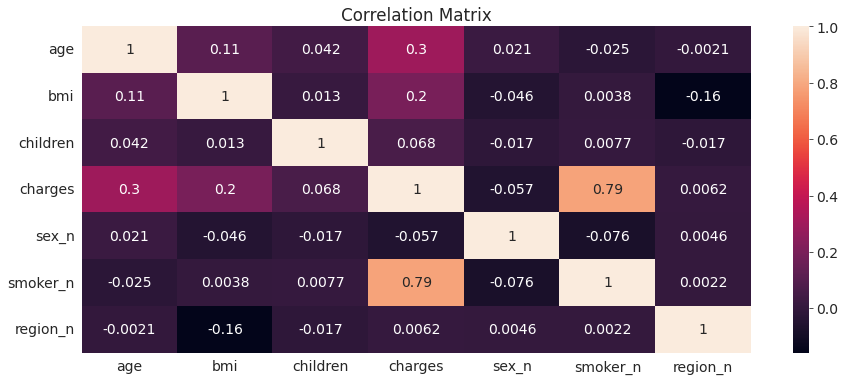

In [340]:
sns.heatmap(data = df.corr(),annot = True ).set_title('Correlation Matrix');

Note: We should remember correlation doesn't mean causation and confounding may exists. 

# Linear Regression

Machine learning has 3 components:
* model
* cost function
* optimiser

Let's first create a baseline model with age as a feature. 

We are using Age as the feature and not Smoker because age has continuous values. 

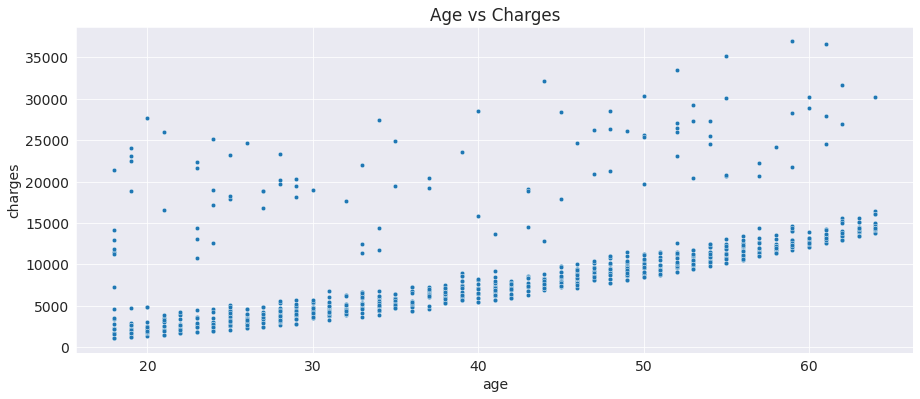

In [341]:
non_smoker_df = df[df.smoker=='no']
sns.scatterplot(data=non_smoker_df, x='age',y='charges',s=20).set_title('Age vs Charges');

Apart from few outliers, points form a line. So we'll try to fit our datapoints on the line and use it to predict charges given the age.

y = mx + c, or

y = wx + b

charges = slope * age + intercept,

we need to find slope(weight), intercept(slope) that fits the data

In [342]:
def predictions(age,w,b):
  return w*age + b

# rmse: root mean square estimate | cost function to figure out if model is good 
def rmse(targets, predictions):
    return np.sqrt(np.mean(np.square(targets - predictions)))

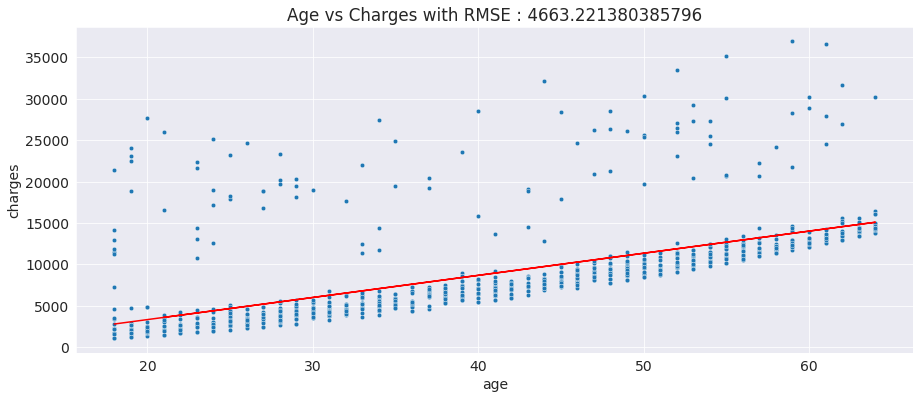

In [343]:
w = 267
b = -2000
plt.plot(non_smoker_df.age, predictions(non_smoker_df.age,w,b),'r')
res = rmse(non_smoker_df.charges, predictions(non_smoker_df.age,w,b))
sns.scatterplot(data=non_smoker_df, x='age',y='charges',s=20).set_title('Age vs Charges with RMSE : '+ str(res));

Let's use scikit library instead of trying to fit model manually

# Linear Reression using Scikit-learn

When there are multiple features model looks like:

y = w1.x1 + w2.x2 + w3.x3 + ... + b

In [344]:
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.model_selection import train_test_split


Let's encode region column using OneHotEncoder  

In [345]:
encoder = OneHotEncoder().fit(df[['region']])
encoder.categories_

[array(['northeast', 'northwest', 'southeast', 'southwest'], dtype=object)]

In [346]:
region_enc = encoder.transform(df[['region']]).toarray()
df[['northeast', 'northwest', 'southeast', 'southwest']] = region_enc

Let's scale the numerical values 

In [347]:
scaler = StandardScaler().fit(df[['age','bmi','children']])
scaler_values = scaler.transform(df[['age','bmi','children']])
df[['age_std','bmi_std','children_std']] = scaler_values

Now  we'll split data into train and test. 

Then train our model on 90% of train data and 

evaluate cost function, RMSE on the test data 

In [348]:
inputs, targets = df[['age_std','bmi_std','children_std','smoker_n','sex_n','northeast', 'northwest', 'southeast', 'southwest']],df[['charges']]
inputs_train, inputs_test, targets_train, targets_test = train_test_split(inputs, targets, test_size=0.1)
model = LinearRegression().fit(inputs_train, targets_train)
rmse(targets_test,model.predict(inputs_test))

charges    6229.466056
dtype: float64

Features are sorted by their weight in the Model which has 5165.07996 RMSE loss

In [349]:
pd.DataFrame({'feature':['age_std','bmi_std','children_std','smoker_n','sex_n','northeast', 'northwest', 'southeast', 'southwest'],
              'weight':model.coef_[0]}).sort_values('weight',ascending=False)  

,feature,weight
3,smoker_n,24175.299740
0,age_std,3649.069805
1,bmi_std,2099.662450
5,northeast,624.772846
2,children_std,620.082212
6,northwest,390.754868
4,sex_n,180.514787
8,southwest,-450.967863
7,southeast,-564.559851


In order to optimize our model, we'll split data into two dataframes, one for smoker, another for non-smokers.

Let's see if that optimizes our loss function.

In [350]:
smoker_df = df[df.smoker=='yes']
non_smoker_df = df[df.smoker=='yes']

In [351]:
inputs, targets = smoker_df[['age_std','bmi_std','children_std','sex_n','northeast', 'northwest', 'southeast', 'southwest']],smoker_df[['charges']]
inputs_train, inputs_test, targets_train, targets_test = train_test_split(inputs, targets, test_size=0.1)
model1 = LinearRegression().fit(inputs_train, targets_train)
print(rmse(targets_test,model1.predict(inputs_test)))
model1.coef_

charges    5387.041083
dtype: float64


array([[ 3765.82471033,  9079.9341539 ,   188.90181387,   718.37430165,
          946.58184386,   280.10840981, -1175.74487087,   -50.94538281]])

In [352]:
inputs, targets = non_smoker_df[['age_std','bmi_std','children_std','sex_n','northeast', 'northwest', 'southeast', 'southwest']],non_smoker_df[['charges']]
inputs_train, inputs_test, targets_train, targets_test = train_test_split(inputs, targets, test_size=0.1)
model2 = LinearRegression().fit(inputs_train, targets_train)
print(rmse(targets_test,model2.predict(inputs_test)))
model2.coef_

charges    5726.311849
dtype: float64


array([[ 3653.00262838,  9127.47487216,   203.38237418,   256.32377301,
          831.01120945,   264.19247059, -1332.62845618,   237.42477614]])

Two models in this case do seem to be better than one.